# Changing the spectra per epoch

In [1]:
import os
import numpy as np
from astropy.io import fits
from astropy import units as u
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
import os
from concurrent.futures import ThreadPoolExecutor
import time
import gc
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
from tensorflow.keras.callbacks import EarlyStopping




2024-09-30 15:05:49.183893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 15:05:49.200313: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 15:05:49.205411: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 15:05:49.220465: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 15:05:50.579567: W tensorflow/compiler/tf2

## Convnet function

In [2]:
def create_convnet(input_shape, num_classes, 
                   num_filters=[128, 128, 128, 128, 128, 128, 128, 128], 
                   kernel_size=(9,),
                   dense_units1=128, 
                   dense_units2=64,
                   dense_units3=32,
                   dropout_rate=0.2,
                   padding='same'):
    model = tf.keras.models.Sequential()
    
    # First convolutional layer
    model.add(tf.keras.layers.Conv1D(filters=num_filters[0], kernel_size=kernel_size, 
                                     activation='relu', input_shape=input_shape, padding=padding))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Additional convolutional layers
    for filters in num_filters[1:]:
        model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                         activation='relu', padding=padding))
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Flatten the output and add dense layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=dense_units1, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # Adding another dense layer
    if dense_units2:
        model.add(tf.keras.layers.Dense(units=dense_units2, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # Adding another dense layer
    if dense_units3:
        model.add(tf.keras.layers.Dense(units=dense_units3, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Output layer
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

    # Optimizer and loss function
    optimizer_ = tf.keras.optimizers.AdamW(learning_rate=1e-4) 

    # Compile the model
    model.compile(optimizer=optimizer_, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [23]:
len_ = 3748
file_list, labels = generate_file_list(limit_per_dir=1)

# Now use these datasets to train the model
convnet_model = create_convnet(input_shape=(len_-10, 1), num_classes=len(set(labels)))

convnet_model.summary()

Gathering FITS files...
Total spectra files collected: 8


/home/jcwind/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3738, 128)      │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1869, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1869, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 934, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 934, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 934, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 467, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 467, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 467, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 233, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 233, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 233, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 116, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 116, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 116, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 58, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 58, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 58, 128)        │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 29, 128)        │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       229,50

 Total params: 1,274,340 (4.86 MB)

 Trainable params: 1,274,340 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Create TensorFlow datasets using the loaded data
def create_tf_dataset(spectra_data, labels, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((spectra_data, labels))
    dataset = dataset.shuffle(buffer_size=len(spectra_data)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def removenan(train_spectra, train_labels, val_spectra, val_labels): 
   # Convert lists to NumPy arrays (remove first 10 spectra to avoid excess NaN values)
    train_spectraa = np.array(train_spectra[10:, :])
    train_labelsa = np.array(train_labels[10:])

    val_spectraa = np.array(val_spectra[10:, :])
    val_labelsa = np.array(val_labels[10:])

    # Remove nan values from the spectra
    mask_train = ~np.isnan(train_spectraa).any(axis=1)
    train_spectranan = train_spectraa[mask_train]
    train_labelsnan = train_labelsa[mask_train]

    mask_val = ~np.isnan(val_spectraa).any(axis=1)
    val_spectranan = val_spectraa[mask_val]
    val_labelsnan = val_labelsa[mask_val]

    del val_spectraa, val_labelsa, mask_val, train_spectraa, train_labelsa, mask_train
    gc.collect()

    # Create TensorFlow datasets
    train_dataset = create_tf_dataset(train_spectranan, train_labelsnan)
    val_dataset = create_tf_dataset(val_spectranan, val_labelsnan)

    del train_spectranan, train_labelsnan
    gc.collect()
    return train_dataset, val_dataset, val_spectranan, val_labelsnan


In [20]:
train_dataset, val_dataset = generate_random_dataset(lim_per_label = 2000)

Gathering FITS files...
Total spectra files collected: 9299


NameError: name 'split_dataset' is not defined

In [6]:
# Function to train the model with the training and validation datasets
def train_convnet(model, lim_per_label = 2000, epochs=1, batch_size=32, patience=5):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    train_dataset, val_dataset = generate_random_dataset(lim_per_label = lim_per_label)
    # Fit the model
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping])
    
    return history

def train_convnet_many_times(model, epochs_per_run=1, batch_size=32, num_runs=10):
    histories = []
    for i in range(num_runs):
        print(f"Training run {i+1}/{num_runs}...")
        history = train_convnet(model, epochs=epochs_per_run , batch_size=batch_size)
        histories.append(history)
    return histories

## Training it

In [21]:
histories = train_convnet_many_times(convnet_model, epochs_per_run=1, batch_size=32, num_runs=25)

NameError: name 'convnet_model' is not defined

In [31]:
print(train_spectra.shape)



NameError: name 'train_spectra' is not defined

In [50]:
# Save the model
convnet_model.save('convnet_model_v1.keras')

In [29]:
def print_confusion_matrix(convnet_model, val_spectranan, val_labelsnan):   
    # Make predictions on the validation/test dataset
    val_predictions = convnet_model.predict(val_spectranan)

    # Convert the predictions to class labels (assuming one-hot encoding)
    predicted_labels = np.argmax(val_predictions, axis=1)

    # Convert true labels if they are in one-hot encoded format
    true_labels = np.array(val_labelsnan)  # Assuming val_labels is already numeric


    # Generate the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    # Optionally, print a classification report for more metrics
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Galaxy', 'Star', 'AGN', 'Binary Star'], yticklabels=['Galaxy', 'Star', 'AGN', 'Binary Star'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Confusion Matrix:
[[389   4   9   0]
 [  2 318   3  76]
 [ 49   4 363   2]
 [  2 143   2 224]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       402
           1       0.68      0.80      0.73       399
           2       0.96      0.87      0.91       418
           3       0.74      0.60      0.67       371

    accuracy                           0.81      1590
   macro avg       0.82      0.81      0.81      1590
weighted avg       0.82      0.81      0.81      1590



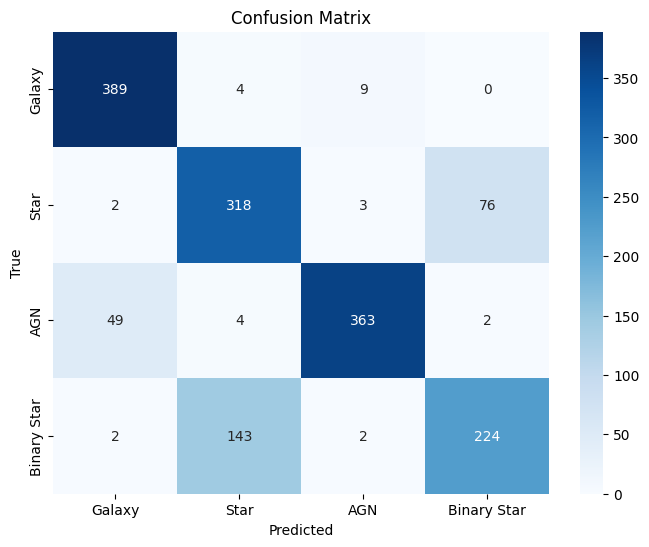

In [49]:
print_confusion_matrix(convnet_model, val_spectranan, val_labelsnan)

# Training very deep convnet

In [24]:
filters_20=[1024, 1024, 1024, 512, 512, 5122 256, 256, 256, 128, 128, 128]
model_20 = create_convnet(input_shape=(len_-10, 1), num_classes=len(set(labels)), num_filters=filters_20, kernel_size=(9,))
model_20.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 3738, 1024)     │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 1869, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 1869, 1024)     │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 934, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 934, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 934, 512)       │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 467, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 467, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 467, 512)       │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 233, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 233, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 233, 256)       │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 116, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 116, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 116, 256)       │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 58, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 58, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 58, 256)        │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 29, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 29, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 29, 128)        │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 14, 128)        │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 7, 128)         │             

 Total params: 19,537,380 (74.53 MB)

 Trainable params: 19,537,380 (74.53 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
def generate_file_list_from_directories(base_dirs, limit_per_dir=10000):
    """Generates a list of files and labels from the pre-separated directories."""
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    print("Gathering FITS files from pre-separated directories...")
    for dir_name, label in spectra_dirs.items():
        for base_dir in base_dirs:
            dir_path = os.path.join(base_dir, dir_name)
            dir_files = []

            # Collect all files in the directory
            for root, dirs, files in os.walk(dir_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    dir_files.append(file_path)

            # Randomly select files up to the limit
            if len(dir_files) > limit_per_dir:
                selected_files = random.sample(dir_files, limit_per_dir)
            else:
                selected_files = dir_files

            # Append selected files and their labels
            file_list.extend(selected_files)
            labels.extend([label] * len(selected_files))

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels


def generate_datasets_from_preseparated(limit_per_dir=10000):
    """Generates training and validation datasets directly from pre-separated directories."""
    train_base_dir = os.path.join(os.getcwd(), "training_set")
    val_base_dir = os.path.join(os.getcwd(), "validation_set")

    # Load files and labels from the respective directories
    train_files, train_labels = generate_file_list_from_directories([train_base_dir], limit_per_dir)
    val_files, val_labels = generate_file_list_from_directories([val_base_dir], limit_per_dir)

    # Load spectra data in parallel
    train_spectra = load_all_spectra_parallel(train_files)
    val_spectra = load_all_spectra_parallel(val_files)

    # Create TensorFlow datasets
    train_dataset, val_dataset, val_spectranan, val_labelsnan = removenan(train_spectra, train_labels, val_spectra, val_labels)
    
    return train_dataset, val_dataset, val_spectranan, val_labelsnan


# Example usage
train_dataset, val_dataset, val_spectranan, val_labelsnan  = generate_datasets_from_preseparated(limit_per_dir=2000)


Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 374.15it/s]


In [58]:
import os
import random
import numpy as np
import tensorflow as tf
from astropy.io import fits
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor


# Create TensorFlow datasets using the loaded data
def create_tf_dataset(spectra_data, labels, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((spectra_data, labels))
    dataset = dataset.shuffle(buffer_size=len(spectra_data)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def removenan(train_spectra, train_labels, val_spectra, val_labels): 
   # Convert lists to NumPy arrays (remove first 10 spectra to avoid excess NaN values)
    train_spectraa = np.array(train_spectra[10:, :])
    train_labelsa = np.array(train_labels[10:])

    val_spectraa = np.array(val_spectra[10:, :])
    val_labelsa = np.array(val_labels[10:])

    # Remove nan values from the spectra
    mask_train = ~np.isnan(train_spectraa).any(axis=1)
    train_spectranan = train_spectraa[mask_train]
    train_labelsnan = train_labelsa[mask_train]

    mask_val = ~np.isnan(val_spectraa).any(axis=1)
    val_spectranan = val_spectraa[mask_val]
    val_labelsnan = val_labelsa[mask_val]

    del val_spectraa, val_labelsa, mask_val, train_spectraa, train_labelsa, mask_train
    gc.collect()

    # Create TensorFlow datasets
    train_dataset = create_tf_dataset(train_spectranan, train_labelsnan)
    val_dataset = create_tf_dataset(val_spectranan, val_labelsnan)

    del train_spectranan, train_labelsnan
    gc.collect()
    return train_dataset, val_dataset, val_spectranan, val_labelsnan


def generate_file_list_from_directories(base_dirs, limit_per_dir=10000):
    """Generates a list of files and labels from the pre-separated directories."""
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    print("Gathering FITS files from pre-separated directories...")
    for dir_name, label in spectra_dirs.items():
        for base_dir in base_dirs:
            dir_path = os.path.join(base_dir, dir_name)
            dir_files = []

            # Collect all files in the directory
            for root, dirs, files in os.walk(dir_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    dir_files.append(file_path)

            # Randomly select files up to the limit
            if len(dir_files) > limit_per_dir:
                selected_files = random.sample(dir_files, limit_per_dir)
            else:
                selected_files = dir_files

            # Append selected files and their labels
            file_list.extend(selected_files)
            labels.extend([label] * len(selected_files))

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels



def generate_datasets_from_preseparated(limit_per_dir=10000):
    """Generates training and validation datasets directly from pre-separated directories."""
    train_base_dir = os.path.join(os.getcwd(), "training_set")
    val_base_dir = os.path.join(os.getcwd(), "validation_set")

    # Load files and labels from the respective directories
    train_files, train_labels = generate_file_list_from_directories([train_base_dir], limit_per_dir)
    val_files, val_labels = generate_file_list_from_directories([val_base_dir], limit_per_dir)

    # Load spectra data in parallel
    train_spectra = load_all_spectra_parallel(train_files)
    val_spectra = load_all_spectra_parallel(val_files)

    # Create TensorFlow datasets
    train_dataset, val_dataset, val_spectranan, val_labelsnan = removenan(train_spectra, train_labels, val_spectra, val_labels)
    
    return train_dataset, val_dataset, val_spectranan, val_labelsnan



def generate_file_list(root_dir=".", limit_per_dir=10000):
    spectra_dirs = {
        "training_set/gal_spectra": 0,  # Label 0 for galaxies
        "training_set/star_spectra": 1,  # Label 1 for stars
        "training_set/agn_spectra": 2,   # Label 2 for AGNs
        "training_set/bin_spectra": 3,   # Label 3 for binary stars
        "validation_set/gal_spectra": 0,  # Label 0 for galaxies (validation)
        "validation_set/star_spectra": 1,  # Label 1 for stars (validation)
        "validation_set/agn_spectra": 2,   # Label 2 for AGNs (validation)
        "validation_set/bin_spectra": 3    # Label 3 for binary stars (validation)
    }

    file_list = []
    labels = []

    print("Gathering FITS files...")
    for dir_name, label in spectra_dirs.items():
        dir_path = os.path.join(root_dir, dir_name)
        dir_files = []

        # Collect all files in the directory
        for root, dirs, files in os.walk(dir_path):
            for file in files:
                file_path = os.path.join(root, file)
                dir_files.append(file_path)
        
        # Randomly select files up to the limit
        if len(dir_files) > limit_per_dir:
            selected_files = random.sample(dir_files, limit_per_dir)
        else:
            selected_files = dir_files
        
        # Append selected files and their labels
        file_list.extend(selected_files)
        labels.extend([label] * len(selected_files))

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels


def create_dataset(file_list, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((file_list, labels))

    def load_and_parse(file_path, label):
        spectra = tf.py_function(load_spectra, [file_path], tf.float32)
        return spectra, label

    dataset = dataset.map(load_and_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(file_list)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


def normalize_spectra(spectra):
    """Normalize spectra by dividing by the mean and applying the natural logarithm."""
    mean_value = np.mean(spectra)
    std_value = np.std(spectra)
    min_value = np.min(spectra)
    if std_value == 0:
        print("Warning: Standard deviation is zero, cannot normalize spectra.")
        return spectra  # Avoid division by zero
    normalized_spectra = ((spectra - min_value + 0.01) / (mean_value - min_value + 0.01)) - 1  # Avoid negative values
    return normalized_spectra



# Example usage
# histories = train_convnet_many_times(convnet_model, epochs_per_run=1, batch_size=32, num_runs=5)

def load_spectra(file_list, target_length=3748):
    """Load spectra from a list of FITS file paths."""
    spectra_data = []
    for file_path in file_list:
        spectra = load_single_spectrum(file_path, target_length)
        if spectra is not None:
            spectra_data.append(spectra)
    return np.array(spectra_data)


def tf_load_single_spectrum(file_path, target_length=3748):
    """TensorFlow wrapper for loading a single spectrum using py_function."""
    spectra = tf.py_function(load_single_spectrum, [file_path, target_length], tf.float32)
    spectra.set_shape([target_length])  # Set the shape explicitly for TensorFlow to optimize
    return spectra


def create_dataset(file_list, labels, batch_size=32, target_length=3748):
    """Create TensorFlow dataset with parallelized loading and optimization."""
    dataset = tf.data.Dataset.from_tensor_slices((file_list, labels))

    def load_and_preprocess(file_path, label):
        spectra = tf_load_single_spectrum(file_path, target_length)
        return spectra, label

    # Apply parallelism and optimizations
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()  # Cache the dataset after loading it once
    dataset = dataset.shuffle(buffer_size=len(file_list))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch to overlap data loading and training

    return dataset
def load_all_spectra_parallel(file_list, target_length=3748, max_workers=512):
    """Load and normalize spectra in parallel using ThreadPoolExecutor."""
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(lambda f: load_single_spectrum(f, target_length), file_list), 
                            total=len(file_list), desc="Loading spectra"))
    # Filter out None results
    spectra_data = [spectrum for spectrum in results if spectrum is not None]
    return np.array(spectra_data)

# Load the validation dataset once and keep it in memory
def load_validation_dataset(limit_per_label=2000):
    val_dataset = generate_datasets_from_preseparated(limit_per_dir=limit_per_label)[1]
    return val_dataset

# Function to train the model with the training dataset and pre-loaded validation dataset
def train_convnet(model, val_dataset, limit_per_label=2000, epochs=1, batch_size=32, patience=5):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Load only the training dataset
    train_dataset= generate_datasets_from_preseparated(limit_per_dir=limit_per_label)[0]
    
    # Fit the model using the pre-loaded validation dataset
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping])
    
    return history

# Function to train the model multiple times
def train_convnet_many_times(model, val_dataset, epochs_per_run=1, batch_size=32, num_runs=10, limit_per_label=2000):
    histories = []
    for i in range(num_runs):
        print(f"Training run {i+1}/{num_runs}...")
        history = train_convnet(model, val_dataset, limit_per_label=limit_per_label, epochs=epochs_per_run, batch_size=batch_size)
        histories.append(history)
    
    return histories



In [62]:
# val_dataset = load_validation_dataset(limit_per_label=2000)
histories = train_convnet_many_times(convnet_model, val_dataset, epochs_per_run=10, batch_size=32, num_runs=25)

Training run 1/25...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:05<00:00, 305.13it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7998 - loss: 0.4361 - val_accuracy: 0.8119 - val_loss: 0.4031
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8113 - loss: 0.4023 - val_accuracy: 0.8189 - val_loss: 0.4071
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8156 - loss: 0.3934 - val_accuracy: 0.8189 - val_loss: 0.3919
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8189 - loss: 0.3857 - val_accuracy: 0.8252 - val_loss: 0.3920
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8195 - loss: 0.4021 - val_accuracy: 0.8201 - val_loss: 0.4011
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8185 - loss: 0.3832 - val_accuracy: 0.8283 - val_loss: 0.3927
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8209 - loss: 0.3771 - val_accuracy: 0.8176 - val_loss: 0.4027
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8131 - loss: 0.3852 - val_accu

Loading spectra: 100%|██████████| 1600/1600 [00:06<00:00, 235.98it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8131 - loss: 0.4001 - val_accuracy: 0.8289 - val_loss: 0.3951
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8141 - loss: 0.4001 - val_accuracy: 0.8308 - val_loss: 0.3842
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8182 - loss: 0.3924 - val_accuracy: 0.8296 - val_loss: 0.3876
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8281 - loss: 0.3801 - val_accuracy: 0.8358 - val_loss: 0.3913
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8248 - loss: 0.3732 - val_accuracy: 0.8289 - val_loss: 0.3850
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8284 - loss: 0.3690 - val_accuracy: 0.8283 - val_loss: 0.3896
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8350 - loss: 0.3568 - val_accuracy: 0.8333 - val_loss: 0.4071
Training run 3/25...
Gathering FITS files from pre-separated directories...
Total spectra files c

Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 333.94it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8077 - loss: 0.4095 - val_accuracy: 0.8258 - val_loss: 0.4106
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8062 - loss: 0.3986 - val_accuracy: 0.8252 - val_loss: 0.3929
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8124 - loss: 0.3894 - val_accuracy: 0.8258 - val_loss: 0.3979
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8108 - loss: 0.3869 - val_accuracy: 0.8340 - val_loss: 0.3854
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8231 - loss: 0.3877 - val_accuracy: 0.8308 - val_loss: 0.3943
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8166 - loss: 0.3852 - val_accuracy: 0.8358 - val_loss: 0.3849
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8200 - loss: 0.3775 - val_accuracy: 0.8296 - val_loss: 0.3974
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8179 - loss: 0.3821 - val_accu

Loading spectra: 100%|██████████| 1600/1600 [00:05<00:00, 273.81it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8225 - loss: 0.3830 - val_accuracy: 0.8289 - val_loss: 0.3981
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8133 - loss: 0.3887 - val_accuracy: 0.8283 - val_loss: 0.3947
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8099 - loss: 0.3846 - val_accuracy: 0.8308 - val_loss: 0.3913
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8176 - loss: 0.3861 - val_accuracy: 0.8258 - val_loss: 0.3963
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8151 - loss: 0.3839 - val_accuracy: 0.8270 - val_loss: 0.3971
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8187 - loss: 0.3751 - val_accuracy: 0.8226 - val_loss: 0.4009
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8256 - loss: 0.3721 - val_accuracy: 0.8308 - val_loss: 0.4043
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8271 - loss: 0.3623 - val_accu

Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 323.63it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8029 - loss: 0.4211 - val_accuracy: 0.8270 - val_loss: 0.3971
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8134 - loss: 0.3988 - val_accuracy: 0.8403 - val_loss: 0.3844
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8130 - loss: 0.3852 - val_accuracy: 0.8283 - val_loss: 0.3951
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8109 - loss: 0.3830 - val_accuracy: 0.8308 - val_loss: 0.3898
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8165 - loss: 0.3942 - val_accuracy: 0.8327 - val_loss: 0.3951
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8272 - loss: 0.3663 - val_accuracy: 0.8352 - val_loss: 0.3944
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8157 - loss: 0.3753 - val_accuracy: 0.8252 - val_loss: 0.3880
Training run 6/25...
Gathering FITS files from pre-separated directories...
Total spectra files c

Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 337.11it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8098 - loss: 0.3900 - val_accuracy: 0.8270 - val_loss: 0.3879
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8099 - loss: 0.3827 - val_accuracy: 0.8321 - val_loss: 0.3898
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8234 - loss: 0.3743 - val_accuracy: 0.8264 - val_loss: 0.3941
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8240 - loss: 0.3677 - val_accuracy: 0.8346 - val_loss: 0.3888
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8098 - loss: 0.3827 - val_accuracy: 0.8358 - val_loss: 0.3866
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8299 - loss: 0.3543 - val_accuracy: 0.8314 - val_loss: 0.3863
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8204 - loss: 0.3643 - val_accuracy: 0.8321 - val_loss: 0.3921
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8169 - loss: 0.3775 - val_accu

Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 351.24it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8244 - loss: 0.3698 - val_accuracy: 0.8371 - val_loss: 0.3870
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8345 - loss: 0.3561 - val_accuracy: 0.8308 - val_loss: 0.3876
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8217 - loss: 0.3676 - val_accuracy: 0.8377 - val_loss: 0.3860
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8361 - loss: 0.3539 - val_accuracy: 0.8333 - val_loss: 0.4005
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8346 - loss: 0.3462 - val_accuracy: 0.8157 - val_loss: 0.4097
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8297 - loss: 0.3527 - val_accuracy: 0.8296 - val_loss: 0.4018
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8283 - loss: 0.3552 - val_accuracy: 0.8283 - val_loss: 0.3974
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8342 - loss: 0.3425 - val_accu

Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 397.94it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8120 - loss: 0.3939 - val_accuracy: 0.8365 - val_loss: 0.3847
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8207 - loss: 0.3767 - val_accuracy: 0.8340 - val_loss: 0.3851
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8168 - loss: 0.3727 - val_accuracy: 0.8415 - val_loss: 0.3804
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8173 - loss: 0.3854 - val_accuracy: 0.8358 - val_loss: 0.3845
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8164 - loss: 0.3626 - val_accuracy: 0.8333 - val_loss: 0.3924
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8187 - loss: 0.3660 - val_accuracy: 0.8340 - val_loss: 0.3879
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8282 - loss: 0.3455 - val_accuracy: 0.8333 - val_loss: 0.3841
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8304 - loss: 0.3558 - val_accu

Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 418.68it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8115 - loss: 0.3728 - val_accuracy: 0.8346 - val_loss: 0.3878
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8387 - loss: 0.3532 - val_accuracy: 0.8296 - val_loss: 0.3923
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8267 - loss: 0.3702 - val_accuracy: 0.8346 - val_loss: 0.3837
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8299 - loss: 0.3545 - val_accuracy: 0.8358 - val_loss: 0.3822
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8339 - loss: 0.3499 - val_accuracy: 0.8226 - val_loss: 0.4086
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8340 - loss: 0.3561 - val_accuracy: 0.8390 - val_loss: 0.3906
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8357 - loss: 0.3480 - val_accuracy: 0.8340 - val_loss: 0.3950
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8301 - loss: 0.3544 - val_accu

Loading spectra: 100%|██████████| 1600/1600 [00:06<00:00, 254.18it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8105 - loss: 0.3824 - val_accuracy: 0.8365 - val_loss: 0.3802
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8212 - loss: 0.3723 - val_accuracy: 0.8314 - val_loss: 0.3837
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8191 - loss: 0.3688 - val_accuracy: 0.8371 - val_loss: 0.3841
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8215 - loss: 0.3685 - val_accuracy: 0.8346 - val_loss: 0.3896
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8328 - loss: 0.3508 - val_accuracy: 0.8314 - val_loss: 0.3821
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8339 - loss: 0.3501 - val_accuracy: 0.8390 - val_loss: 0.3866
Training run 11/25...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 385.04it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8198 - loss: 0.3773 - val_accuracy: 0.8421 - val_loss: 0.3828
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8245 - loss: 0.3701 - val_accuracy: 0.8333 - val_loss: 0.3823
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8303 - loss: 0.3597 - val_accuracy: 0.8308 - val_loss: 0.3930
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8285 - loss: 0.3545 - val_accuracy: 0.8434 - val_loss: 0.3766
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8306 - loss: 0.3440 - val_accuracy: 0.8440 - val_loss: 0.3784
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8296 - loss: 0.3526 - val_accuracy: 0.8358 - val_loss: 0.3872
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8380 - loss: 0.3347 - val_accuracy: 0.8270 - val_loss: 0.3993
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8399 - loss: 0.3324 - val_accu

Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 410.33it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8259 - loss: 0.3676 - val_accuracy: 0.8308 - val_loss: 0.3808
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8326 - loss: 0.3649 - val_accuracy: 0.8409 - val_loss: 0.3758
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8293 - loss: 0.3571 - val_accuracy: 0.8314 - val_loss: 0.3872
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8319 - loss: 0.3490 - val_accuracy: 0.8384 - val_loss: 0.3778
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8330 - loss: 0.3476 - val_accuracy: 0.8428 - val_loss: 0.3814
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8380 - loss: 0.3363 - val_accuracy: 0.8346 - val_loss: 0.3909
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8416 - loss: 0.3334 - val_accuracy: 0.8358 - val_loss: 0.3852
Training run 13/25...
Gathering FITS files from pre-separated directories...
Total spectra files 

Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 404.72it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8160 - loss: 0.4032 - val_accuracy: 0.8447 - val_loss: 0.3727
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8286 - loss: 0.3706 - val_accuracy: 0.8296 - val_loss: 0.3771
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8348 - loss: 0.3519 - val_accuracy: 0.8283 - val_loss: 0.3767
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8410 - loss: 0.3480 - val_accuracy: 0.8277 - val_loss: 0.3835
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8375 - loss: 0.3596 - val_accuracy: 0.8346 - val_loss: 0.3807
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8448 - loss: 0.3350 - val_accuracy: 0.8327 - val_loss: 0.3895
Training run 14/25...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 394.15it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8232 - loss: 0.3787 - val_accuracy: 0.8327 - val_loss: 0.3703
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8312 - loss: 0.3748 - val_accuracy: 0.8358 - val_loss: 0.3684
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8326 - loss: 0.3768 - val_accuracy: 0.8371 - val_loss: 0.3764
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8249 - loss: 0.3771 - val_accuracy: 0.8371 - val_loss: 0.3667
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8410 - loss: 0.3638 - val_accuracy: 0.8371 - val_loss: 0.3790
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8321 - loss: 0.3623 - val_accuracy: 0.8296 - val_loss: 0.3779
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8386 - loss: 0.3546 - val_accuracy: 0.8365 - val_loss: 0.3732
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8360 - loss: 0.3453 - val_accu

Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 374.41it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8328 - loss: 0.3745 - val_accuracy: 0.8308 - val_loss: 0.3840
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8306 - loss: 0.3545 - val_accuracy: 0.8327 - val_loss: 0.3819
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8355 - loss: 0.3564 - val_accuracy: 0.8377 - val_loss: 0.3891
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8356 - loss: 0.3435 - val_accuracy: 0.8358 - val_loss: 0.3799
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8465 - loss: 0.3319 - val_accuracy: 0.8340 - val_loss: 0.3823
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8420 - loss: 0.3361 - val_accuracy: 0.8352 - val_loss: 0.3848
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8383 - loss: 0.3401 - val_accuracy: 0.8377 - val_loss: 0.3788
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8437 - loss: 0.3345 - val_accu

Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 351.13it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8259 - loss: 0.3807 - val_accuracy: 0.8428 - val_loss: 0.3763
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8261 - loss: 0.3732 - val_accuracy: 0.8409 - val_loss: 0.3771
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8346 - loss: 0.3627 - val_accuracy: 0.8289 - val_loss: 0.3868
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8346 - loss: 0.3621 - val_accuracy: 0.8384 - val_loss: 0.3811
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8385 - loss: 0.3566 - val_accuracy: 0.8352 - val_loss: 0.3926
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8434 - loss: 0.3354 - val_accuracy: 0.8289 - val_loss: 0.3908
Training run 17/25...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 331.50it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8398 - loss: 0.3548 - val_accuracy: 0.8358 - val_loss: 0.3756
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8326 - loss: 0.3478 - val_accuracy: 0.8346 - val_loss: 0.3787
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8392 - loss: 0.3400 - val_accuracy: 0.8365 - val_loss: 0.3759
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8450 - loss: 0.3344 - val_accuracy: 0.8264 - val_loss: 0.3772
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8359 - loss: 0.3388 - val_accuracy: 0.8403 - val_loss: 0.3828
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8347 - loss: 0.3372 - val_accuracy: 0.8358 - val_loss: 0.3818
Training run 18/25...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 334.81it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8273 - loss: 0.3552 - val_accuracy: 0.8245 - val_loss: 0.3762
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8442 - loss: 0.3469 - val_accuracy: 0.8327 - val_loss: 0.3747
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8394 - loss: 0.3350 - val_accuracy: 0.8340 - val_loss: 0.3747
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8427 - loss: 0.3343 - val_accuracy: 0.8289 - val_loss: 0.3808
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8462 - loss: 0.3311 - val_accuracy: 0.8264 - val_loss: 0.3823
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8477 - loss: 0.3511 - val_accuracy: 0.8371 - val_loss: 0.3815
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8449 - loss: 0.3291 - val_accuracy: 0.8340 - val_loss: 0.3774
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8505 - loss: 0.3163 - val_accu

Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 358.86it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8270 - loss: 0.3646 - val_accuracy: 0.8384 - val_loss: 0.3736
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8400 - loss: 0.3493 - val_accuracy: 0.8314 - val_loss: 0.3786
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8501 - loss: 0.3289 - val_accuracy: 0.8396 - val_loss: 0.3808
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8367 - loss: 0.3477 - val_accuracy: 0.8396 - val_loss: 0.3816
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8411 - loss: 0.3428 - val_accuracy: 0.8340 - val_loss: 0.3745
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8469 - loss: 0.3386 - val_accuracy: 0.8371 - val_loss: 0.3764
Training run 20/25...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 354.76it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8321 - loss: 0.3600 - val_accuracy: 0.8377 - val_loss: 0.3704
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8278 - loss: 0.3676 - val_accuracy: 0.8346 - val_loss: 0.3675
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8418 - loss: 0.3499 - val_accuracy: 0.8390 - val_loss: 0.3706
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8367 - loss: 0.3467 - val_accuracy: 0.8289 - val_loss: 0.3751
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8357 - loss: 0.3616 - val_accuracy: 0.8352 - val_loss: 0.3811
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8419 - loss: 0.3411 - val_accuracy: 0.8226 - val_loss: 0.3883
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8425 - loss: 0.3416 - val_accuracy: 0.8346 - val_loss: 0.3736
Training run 21/25...
Gathering FITS files from pre-separated directories...
Total spectra files 

Loading spectra: 100%|██████████| 1600/1600 [00:05<00:00, 285.02it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8265 - loss: 0.3759 - val_accuracy: 0.8365 - val_loss: 0.3725
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8346 - loss: 0.3404 - val_accuracy: 0.8346 - val_loss: 0.3840
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8349 - loss: 0.3491 - val_accuracy: 0.8346 - val_loss: 0.3711
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8369 - loss: 0.3533 - val_accuracy: 0.8384 - val_loss: 0.3981
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8422 - loss: 0.3351 - val_accuracy: 0.8352 - val_loss: 0.3970
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8517 - loss: 0.3313 - val_accuracy: 0.8302 - val_loss: 0.3870
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8462 - loss: 0.3275 - val_accuracy: 0.8390 - val_loss: 0.3885
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8381 - loss: 0.3339 - val_accu

Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 354.76it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8234 - loss: 0.3647 - val_accuracy: 0.8403 - val_loss: 0.3666
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8360 - loss: 0.3491 - val_accuracy: 0.8396 - val_loss: 0.3704
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8336 - loss: 0.3462 - val_accuracy: 0.8340 - val_loss: 0.3750
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8383 - loss: 0.3375 - val_accuracy: 0.8358 - val_loss: 0.3778
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8390 - loss: 0.3340 - val_accuracy: 0.8371 - val_loss: 0.3779
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8416 - loss: 0.3275 - val_accuracy: 0.8352 - val_loss: 0.3863
Training run 23/25...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 359.69it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8284 - loss: 0.3731 - val_accuracy: 0.8377 - val_loss: 0.3720
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8353 - loss: 0.3563 - val_accuracy: 0.8371 - val_loss: 0.3742
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8321 - loss: 0.3442 - val_accuracy: 0.8434 - val_loss: 0.3718
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8349 - loss: 0.3526 - val_accuracy: 0.8358 - val_loss: 0.3835
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8400 - loss: 0.3340 - val_accuracy: 0.8434 - val_loss: 0.3801
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8488 - loss: 0.3224 - val_accuracy: 0.8365 - val_loss: 0.3789
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8516 - loss: 0.3245 - val_accuracy: 0.8333 - val_loss: 0.3721
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8410 - loss: 0.3364 - val_accu

Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 330.68it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8398 - loss: 0.3481 - val_accuracy: 0.8403 - val_loss: 0.3639
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8395 - loss: 0.3389 - val_accuracy: 0.8333 - val_loss: 0.3765
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8425 - loss: 0.3421 - val_accuracy: 0.8365 - val_loss: 0.3845
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8417 - loss: 0.3374 - val_accuracy: 0.8396 - val_loss: 0.3814
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8477 - loss: 0.3300 - val_accuracy: 0.8403 - val_loss: 0.3812
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8493 - loss: 0.3158 - val_accuracy: 0.8321 - val_loss: 0.3808
Training run 25/25...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 330.63it/s]


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8353 - loss: 0.3436 - val_accuracy: 0.8352 - val_loss: 0.3805
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8406 - loss: 0.3376 - val_accuracy: 0.8409 - val_loss: 0.3760
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8439 - loss: 0.3151 - val_accuracy: 0.8384 - val_loss: 0.3748
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8428 - loss: 0.3303 - val_accuracy: 0.8403 - val_loss: 0.3714
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8461 - loss: 0.3255 - val_accuracy: 0.8377 - val_loss: 0.3790
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8468 - loss: 0.3190 - val_accuracy: 0.8377 - val_loss: 0.3782
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8513 - loss: 0.3181 - val_accuracy: 0.8384 - val_loss: 0.3872
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8579 - loss: 0.3017 - val_accu

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix:
[[379   3   5   3]
 [  0 283   0 117]
 [ 44   6 348   2]
 [  4  94   0 302]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       390
           1       0.73      0.71      0.72       400
           2       0.99      0.87      0.92       400
           3       0.71      0.76      0.73       400

    accuracy                           0.83      1590
   macro avg       0.83      0.83      0.83      1590
weighted avg       0.83      0.83      0.83      1590



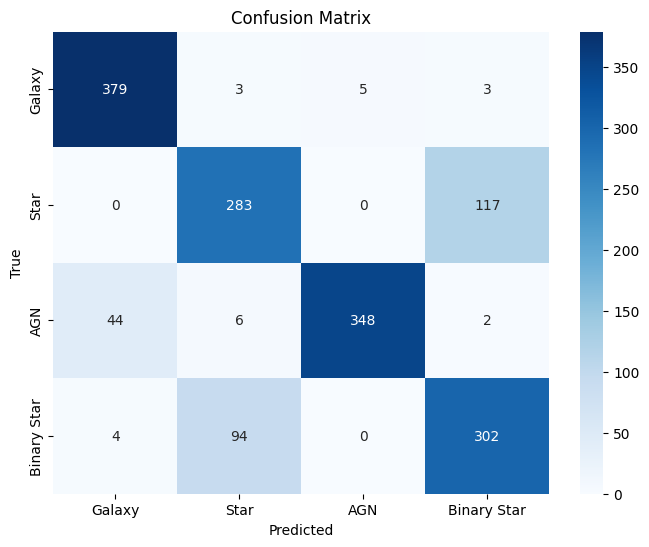

In [61]:
print_confusion_matrix(convnet_model, val_spectranan, val_labelsnan)

# 40 layers for no sane reason

In [61]:
filters_400=[128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
model_40 = create_convnet(input_shape=(len_-10, 1), num_classes=len(set(labels)), num_filters=filters_20, dense_units=256, dropout_rate=0.5, kernel_size=(5,))
model_40.summary()

/home/jcwind/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_236 (Conv1D)             │ (None, 3738, 128)      │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_236               │ (None, 1869, 128)      │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_237 (Conv1D)             │ (None, 1869, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_237               │ (None, 934, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_238 (Conv1D)             │ (None, 934, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_238               │ (None, 467, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_239 (Conv1D)             │ (None, 467, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_239               │ (None, 233, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_240 (Conv1D)             │ (None, 233, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_240               │ (None, 116, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_241 (Conv1D)             │ (None, 116, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_241               │ (None, 58, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_242 (Conv1D)             │ (None, 58, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_242               │ (None, 29, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_243 (Conv1D)             │ (None, 29, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_243               │ (None, 14, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_244 (Conv1D)             │ (None, 14, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_244               │ (None, 7, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_245 (Conv1D)             │ (None, 7, 128)         │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_245               │ (None, 3, 128)         │             0 │
│ (MaxPooling1D)                  │                        │             

 Total params: 3,201,924 (12.21 MB)

 Trainable params: 3,201,924 (12.21 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
histories = train_convnet_many_times(convnet_model, epochs_per_run=1, batch_size=8, num_runs=25)

Training run 1/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 663.98it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8221 - loss: 0.3733 - val_accuracy: 0.8270 - val_loss: 0.3710
Training run 2/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 610.75it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8247 - loss: 0.3899 - val_accuracy: 0.8101 - val_loss: 0.3925
Training run 3/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 569.23it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8248 - loss: 0.3578 - val_accuracy: 0.8208 - val_loss: 0.3690
Training run 4/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 578.30it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8126 - loss: 0.3990 - val_accuracy: 0.8176 - val_loss: 0.3790
Training run 5/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 629.21it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8186 - loss: 0.3864 - val_accuracy: 0.8440 - val_loss: 0.3429
Training run 6/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 573.76it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8212 - loss: 0.3783 - val_accuracy: 0.8377 - val_loss: 0.3517
Training run 7/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 572.00it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8329 - loss: 0.3717 - val_accuracy: 0.8472 - val_loss: 0.3462
Training run 8/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 566.44it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8291 - loss: 0.3701 - val_accuracy: 0.8371 - val_loss: 0.3471
Training run 9/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 553.57it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8219 - loss: 0.3872 - val_accuracy: 0.8245 - val_loss: 0.3859
Training run 10/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 588.42it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8254 - loss: 0.3736 - val_accuracy: 0.8214 - val_loss: 0.3889
Training run 11/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 589.56it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8196 - loss: 0.3836 - val_accuracy: 0.8403 - val_loss: 0.3585
Training run 12/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 658.72it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8327 - loss: 0.3631 - val_accuracy: 0.8478 - val_loss: 0.3431
Training run 13/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 551.85it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8362 - loss: 0.3616 - val_accuracy: 0.8428 - val_loss: 0.3341
Training run 14/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 587.18it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8292 - loss: 0.3771 - val_accuracy: 0.8465 - val_loss: 0.3493
Training run 15/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 650.97it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8372 - loss: 0.3532 - val_accuracy: 0.8390 - val_loss: 0.3616
Training run 16/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 685.20it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8274 - loss: 0.3718 - val_accuracy: 0.8302 - val_loss: 0.3711
Training run 17/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 543.17it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8205 - loss: 0.3640 - val_accuracy: 0.8308 - val_loss: 0.3512
Training run 18/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 614.21it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8316 - loss: 0.3633 - val_accuracy: 0.8252 - val_loss: 0.3654
Training run 19/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 576.90it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8473 - loss: 0.3394 - val_accuracy: 0.8453 - val_loss: 0.3317
Training run 20/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 656.38it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8452 - loss: 0.3471 - val_accuracy: 0.8365 - val_loss: 0.3612
Training run 21/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 564.17it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8273 - loss: 0.3755 - val_accuracy: 0.8447 - val_loss: 0.3422
Training run 22/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 574.48it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8381 - loss: 0.3599 - val_accuracy: 0.8478 - val_loss: 0.3429
Training run 23/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 553.27it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8341 - loss: 0.3587 - val_accuracy: 0.8396 - val_loss: 0.3395
Training run 24/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 583.34it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8289 - loss: 0.3566 - val_accuracy: 0.8528 - val_loss: 0.3484
Training run 25/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 648.23it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8413 - loss: 0.3443 - val_accuracy: 0.8509 - val_loss: 0.3357


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix:
[[397   0   4   1]
 [  1 293   0 105]
 [ 38   1 376   3]
 [  0  87   0 284]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       402
           1       0.77      0.73      0.75       399
           2       0.99      0.90      0.94       418
           3       0.72      0.77      0.74       371

    accuracy                           0.85      1590
   macro avg       0.85      0.85      0.85      1590
weighted avg       0.85      0.85      0.85      1590



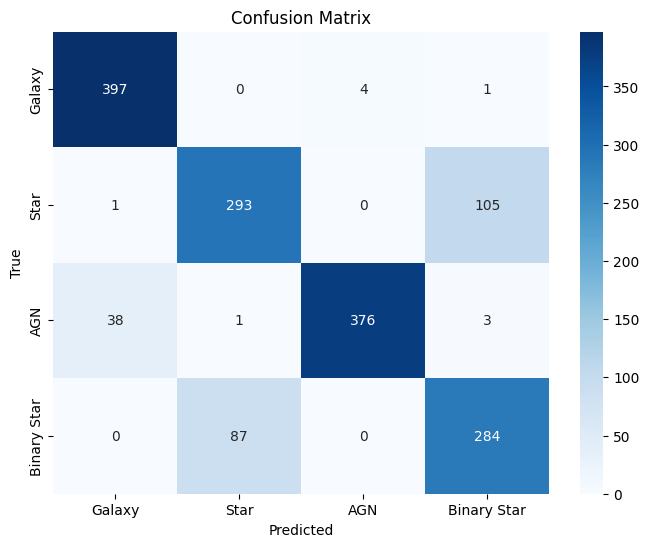

In [60]:
print_confusion_matrix(convnet_model, val_spectranan, val_labelsnan)